# Гусев Яромир ПМ22-6

# Машинное обучение в задачах идентификации личности по изображению

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from PIL import Image
from tqdm import tqdm, trange
import seaborn as sns
from copy import deepcopy
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch
import timm

Для данной задчи я выбрал набор данных CelebA_500, который является подмножеством известного набора данных CelebA, который содержит более 200 000 изображений известных знаменитостей из различных областей, таких как кино, спорт, музыка и т.д. CelebA_500 содержит изображения лишь 500 человек, что делает его более компактным и подходящим для экспериментов и тестирования. Решаемой задачей является классификация личности на основе изображения.

In [74]:
img_names = os.listdir('./celebA_500/celebA_imgs/')
print(f'Всего {len(img_names)} картинок')

Всего 23948 картинок


In [75]:
f = open('celebA_500/celebA_anno.txt')
lines = f.readlines()
dict1 = dict()
for i in range(0,500):
    dict1[i] = []
for i in lines:
    z = i.split()
    dict1[int(z[1])].append(z[0])

a = {1:[2,3]}
names = [dict1[i] for i in dict1]
cnts = [len(dict1[i]) for i in dict1]
df = pd.DataFrame({'images':names,'img_counts':cnts})
df

C:\Users\yarom\AppData\Local\Temp\ipykernel_16460\3307551726.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='celebA_500/celebA_anno.txt' mode='r' encoding='cp1251'>
  f = open('celebA_500/celebA_anno.txt')


,images,img_counts
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
498,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


Выведем  гистограмму распределения количества картинок для каждого класса

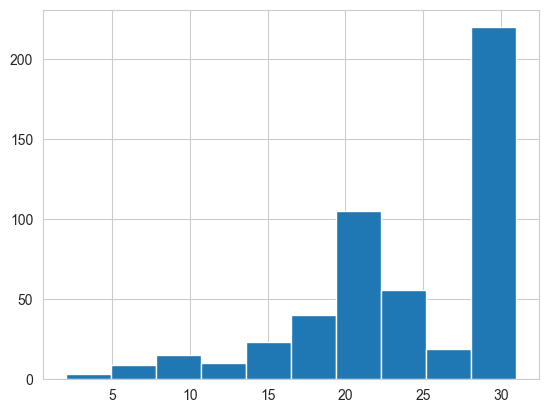

In [76]:
df['img_counts'].hist();

В целом, нет явного дисбаланса классов, так как классы имеют примерно одинаковое количество картинок в выборке.

Выведем 5 случайных картинок людей

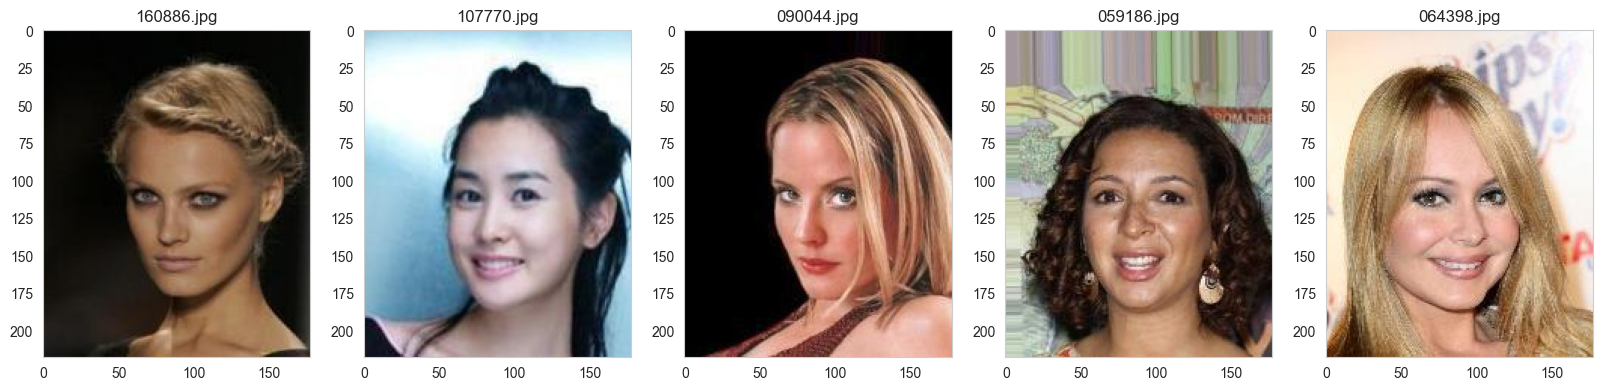

In [78]:
a = [img_names[i] for i in [np.random.randint(0,len(img_names)) for i in range(5)]]
imgs = []
for img in a:
    img = Image.open(os.path.join('celebA_500/celebA_imgs/', img))
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

Выведем 5 картинок одного человека.

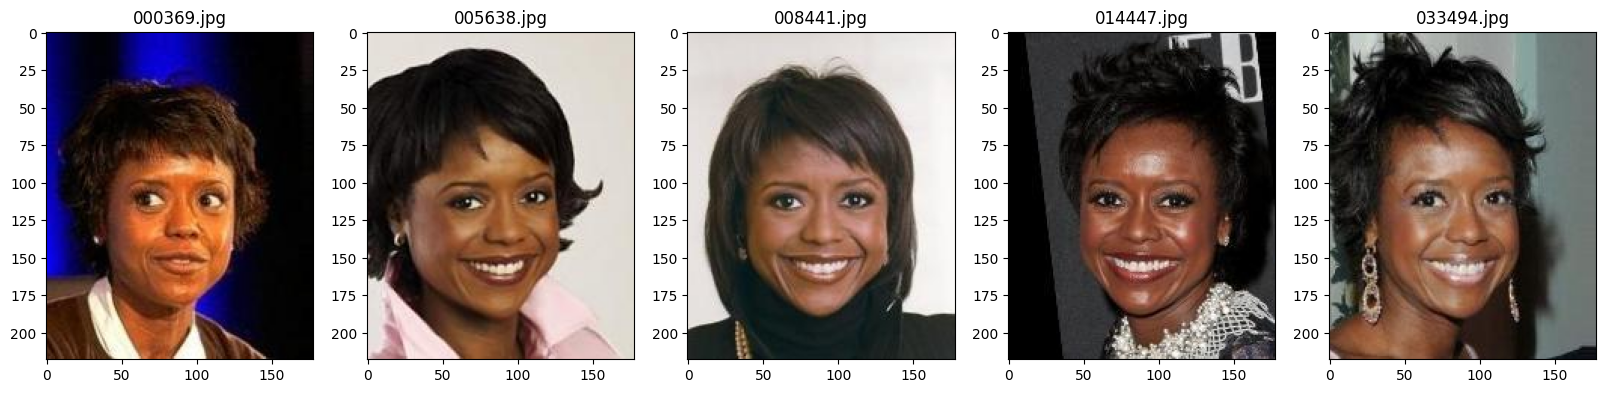

In [ ]:
a = df.iloc[np.random.randint(0,len(df))]['images'][:5]
imgs = []
for img in a:
    img = Image.open(os.path.join('celebA_500/celebA_imgs/', img))
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

In [ ]:
for i in range(len(lines)):
    lines[i] = lines[i].split()[0]
lines

['000001.jpg',
 '000404.jpg',
 '003415.jpg',
 '004390.jpg',
 '018062.jpg',
 '025244.jpg',
 '027771.jpg',
 '039393.jpg',
 '047978.jpg',
 '049142.jpg',
 '052385.jpg',
 '052623.jpg',
 '053184.jpg',
 '053311.jpg',
 '055834.jpg',
 '058188.jpg',
 '061431.jpg',
 '068154.jpg',
 '084705.jpg',
 '090937.jpg',
 '096324.jpg',
 '100990.jpg',
 '103728.jpg',
 '108341.jpg',
 '110376.jpg',
 '122439.jpg',
 '131731.jpg',
 '134007.jpg',
 '139106.jpg',
 '140935.jpg',
 '000002.jpg',
 '011437.jpg',
 '016335.jpg',
 '017121.jpg',
 '024291.jpg',
 '037082.jpg',
 '045318.jpg',
 '046844.jpg',
 '048360.jpg',
 '055891.jpg',
 '057357.jpg',
 '058209.jpg',
 '058400.jpg',
 '059638.jpg',
 '060925.jpg',
 '063242.jpg',
 '063616.jpg',
 '066809.jpg',
 '077346.jpg',
 '095867.jpg',
 '099877.jpg',
 '105287.jpg',
 '108661.jpg',
 '114336.jpg',
 '114625.jpg',
 '117710.jpg',
 '120280.jpg',
 '125140.jpg',
 '142601.jpg',
 '152380.jpg',
 '000003.jpg',
 '015648.jpg',
 '033840.jpg',
 '038887.jpg',
 '049972.jpg',
 '052374.jpg',
 '053297.j

In [ ]:
def load_images_from_folder(folder, lines):
    images = []
    filenames = []
    for filename in tqdm(lines):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames


folder = 'celebA_500/celebA_imgs'
images, filenames = load_images_from_folder(folder, lines)

100%|██████████| 12011/12011 [00:06<00:00, 1787.94it/s]


In [ ]:
images

[array([[[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [216, 228, 246],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [218, 230, 248],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [220, 232, 250],
         [224, 238, 255],
         [223, 239, 255]],
 
        ...,
 
        [[ 26,  74, 140],
         [  1,  49, 115],
         [ 33,  78, 146],
         ...,
         [ 28,  55, 122],
         [ 30,  56, 123],
         [ 30,  56, 122]],
 
        [[ 14,  61, 129],
         [ 21,  68, 136],
         [ 51,  96, 164],
         ...,
         [ 20,  49, 118],
         [ 24,  50, 120],
         [ 24,  51, 118]],
 
        [[ 56, 103, 171],
         [ 90, 137, 205],
         [131, 176, 244],
         ...,
         [ 20,  49, 118],
  

Преобразуем картинки в плоские численные массивы. Я буду получать:

    Гистограммы цветов: Для каждого канала цвета (красный, зелёный, синий) вычисляются гистограммы с использованием функции cv2.calcHist(). Гистограммы каждого канала сглаживаются и объединяются в один вектор признаков.

    HOG (Histogram of Oriented Gradients) признаки: Эти признаки очень много весят, но при этом не особо влияют на качество классификации, так что их не будем использовать.

    LBP (Local Binary Pattern) признаки: Вычисляются признаки LBP с использованием функции local_binary_pattern() из библиотеки scikit-image. Затем эти признаки нормализуются.

    Статистические признаки: Вычисляются среднее, стандартное отклонение, максимальное и минимальное значения для каждого канала цвета.

Все эти признаки объединяются в один общий вектор признаков для каждого изображения.

In [ ]:
def extract_features(images):
    all_features = []
    
    for img in tqdm(images):
        hist_features = []
        for i in range(3):  # Для каждого канала цвета
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_features.extend(hist.flatten())
        
        # HOG features
#         fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
#                             cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        
#         LBP features
        lbp = local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
        
#         Статистические признаки
        mean = np.mean(img, axis=(0, 1))
        std = np.std(img, axis=(0, 1))
        max_ = np.max(img, axis=(0, 1))
        min_ = np.min(img, axis=(0, 1))
        
        # Объединение признаков
        combined_features = np.hstack([
            hist_features,
#             fd,
            lbp_hist,
            mean,
            std,
            max_,
            min_
        ])
        all_features.append(combined_features)
        
    features_df = pd.DataFrame(all_features)
    
    return features_df

X = extract_features(images)

100%|██████████| 12011/12011 [02:16<00:00, 88.25it/s]


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,800,801,802,803,804,805
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,181.045124,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,120.902716,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,106.863442,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,115.390733,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,93.602721,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,114.599191,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,165.123853,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,104.931218,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,87.155603,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0


In [ ]:
targets = []
f = open('celebA_500/celebA_anno.txt')
lines2 = f.readlines()
for i in range(len(lines2)):
    targets.append(int(lines2[i].split()[1]))
targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,


In [ ]:
data = pd.concat([X, pd.Series(targets, name='target')], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


Получился огромный датасет, который я сохраню в csv, чтобы не выполнять feature extraction каждый раз.

In [ ]:
data.to_csv('data.csv')

In [ ]:
data = pd.read_csv('data.csv').drop(['Unnamed: 0'], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


In [ ]:
X = data.drop(["target"], axis=1)
y = data["target"]

Выполню разбиение на тренировочную и тестовую выборки. Размер тестовой выборки равен 20% от всего датасета, так как обучающая выборка должна быть достаточно большой для того, чтобы модель могла изучить разнообразные закономерности в данных, а тестовая выборка должна быть достаточно большой для того, чтобы дать надежную оценку обобщающей способности модели. Также будет использован случайны метод разделения данных, чтобы избежать каких-либо предвзятостей или зависимостей между обучающей и тестовой выборками. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y,
                                                  shuffle=True)

Так как датасет получился крайне большой, необходимо произвести процедуру понижения размерности (PCA), так как иначе все модели будут учиться очень долго, а также нормализацию, для удобства буду использовать make_pipeline из sklearn.

In [ ]:
pipeline = make_pipeline(
    StandardScaler(),  
    PCA(n_components=0.95)
)

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

X_train.shape, X_test.shape

((9608, 275), (2403, 275))

Осталось всего 275 столбцов, которые теперь я буду использовать для обучения моделей. 

Сначала попробую логистическую регрессию.

100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


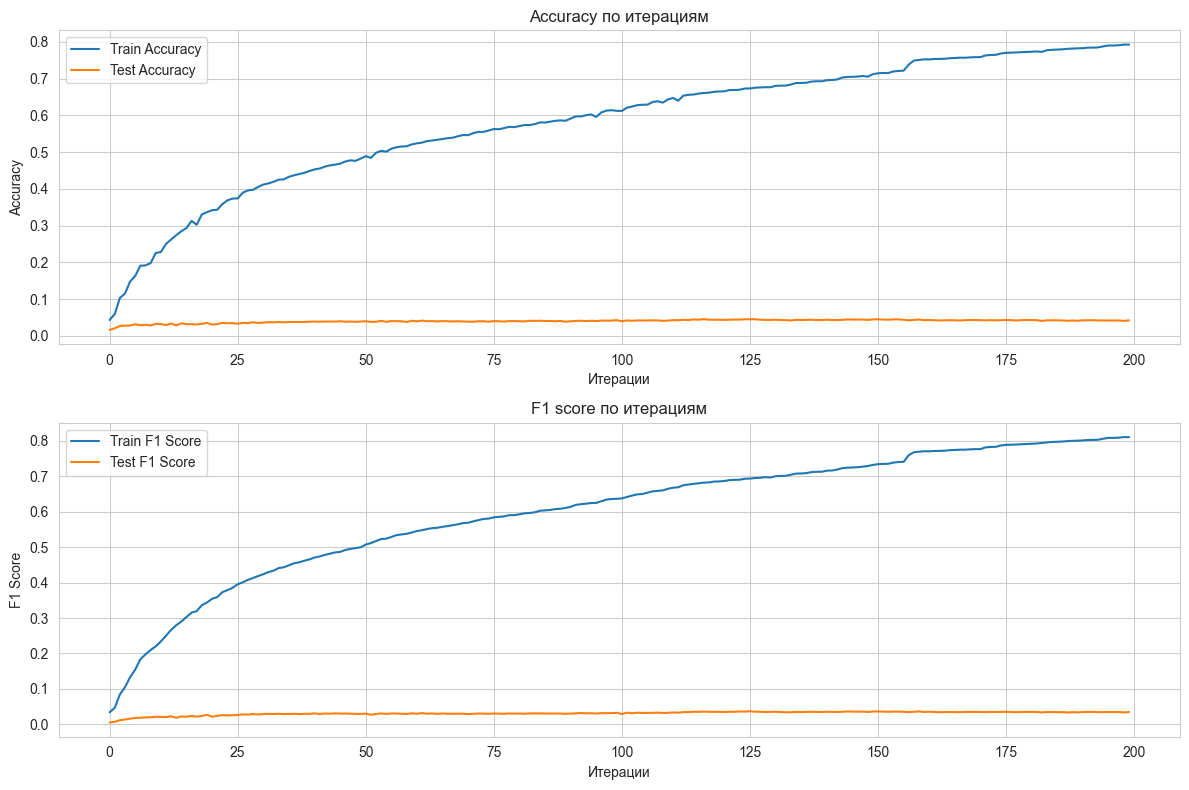

Обучалось 99.62942123413086 секунд


In [ ]:
train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []
start_time = time.time()

model = LogisticRegression(max_iter=1, warm_start=True)

for i in tqdm(range(1, 201)):
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    
    train_f1_score = f1_score(y_train, train_pred, average='macro')
    test_f1_score = f1_score(y_test, test_pred, average='macro')
    train_f1.append(train_f1_score)
    test_f1.append(test_f1_score)
end_time = time.time()
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy по итерациям')
plt.xlabel('Итерации')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_f1, label='Train F1 Score')
plt.plot(test_f1, label='Test F1 Score')
plt.title('F1 score по итерациям')
plt.xlabel('Итерации')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print(f'Обучалось {end_time - start_time} секунд')

In [ ]:
y_pred= model.predict(X_test)
accuracy_score(y_pred, y_test)

0.04203079483978361

Логистическая регрессия сталкивается с проблемой переобучения. Попробую случайный лес, так как ему оно безразличнее.

In [ ]:
start_time = time.time()
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=25)

model_rf.fit(X_train, y_train)
end_time = time.time()
print(f'Обучалось {end_time - start_time} секунд')
y_pred = model_rf.predict(X_test)

accuracy_score(y_pred, y_test)

Обучалось 40.71551847457886 секунд


0.03162713275072826

In [ ]:
y_pred = model_rf.predict(X_train)

accuracy_score(y_pred, y_train)

0.9998959200666112

Здесь тоже самое. Попробую еще SVM, KNN, наивный байес и CatBoost.

In [ ]:
parameters = {
    'C': [0.1, 1, 10],  # Регуляризация
    'kernel': ['linear', 'rbf'],  # Типы ядер
}
start_time = time.time()
svm_model = SVC()
grid_search = GridSearchCV(svm_model, parameters, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
end_time = time.time()
print(f'Обучалось {end_time - start_time} секунд')
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy с лучшими параметрами: {accuracy}")

Лучшие параметры: {'C': 10, 'kernel': 'rbf'}
Обучалось 540.815099477768 секунд
Accuracy с лучшими параметрами: 0.06658343736995423


In [ ]:
start_time = time.time()
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
end_time = time.time()
print(f'Обучалось {end_time - start_time} секунд')
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

Обучалось 0.012995243072509766 секунд


0.026217228464419477

In [ ]:
nb_model = GaussianNB()
start_time = time.time()
nb_model.fit(X_train, y_train)
end_time = time.time()
print(f'Обучалось {end_time - start_time} секунд')
y_pred = nb_model.predict(X_test)
accuracy_score(y_test, y_pred)

Обучалось 0.10299921035766602 секунд


0.02039117769454848

In [ ]:
train_pca_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

In [ ]:
model_cb = CatBoostClassifier(loss_function='MultiClass',
                             random_seed=42,
                             task_type='GPU',
                             iterations=200,
                             depth=5,
                             learning_rate=0.2)
start_time = time.time()
model_cb.fit(train_pca_pool)
end_time = time.time()
print(f'Обучалось {end_time - start_time} секунд')

0:	learn: 6.1479797	total: 8.62s	remaining: 28m 35s
1:	learn: 6.1007559	total: 18.9s	remaining: 31m 14s
2:	learn: 6.0664953	total: 20.5s	remaining: 22m 25s
3:	learn: 6.0179770	total: 22.2s	remaining: 18m 8s
4:	learn: 5.9685910	total: 23.8s	remaining: 15m 29s
5:	learn: 5.9334868	total: 24.7s	remaining: 13m 19s
6:	learn: 5.8789851	total: 25.6s	remaining: 11m 47s
7:	learn: 5.8371848	total: 26.6s	remaining: 10m 37s
8:	learn: 5.7818672	total: 27.5s	remaining: 9m 43s
9:	learn: 5.7455014	total: 28.4s	remaining: 8m 59s
10:	learn: 5.7130524	total: 29.3s	remaining: 8m 22s
11:	learn: 5.6849752	total: 30.1s	remaining: 7m 51s
12:	learn: 5.6435608	total: 31s	remaining: 7m 25s
13:	learn: 5.6149644	total: 31.8s	remaining: 7m 2s
14:	learn: 5.5656273	total: 32.6s	remaining: 6m 41s
15:	learn: 5.5344273	total: 33.3s	remaining: 6m 22s
16:	learn: 5.5031647	total: 34.1s	remaining: 6m 7s
17:	learn: 5.4786095	total: 34.9s	remaining: 5m 52s
18:	learn: 5.4406444	total: 35.7s	remaining: 5m 39s
19:	learn: 5.419571

In [ ]:
y_pred = model_cb.predict(X_test)
accuracy_score(y_test, y_pred)

0.05076987099459009

В целом, методы классического машинного обучения намного хуже справляются с картинками, чем методы глубокого обучения, так что сейчас попробуем дообучить нейронную сеть

In [2]:
def get_paths(dataset_type='train'):
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_500/celebA_train_split.txt')
    lines = f.readlines()
    f.close()

    lines = [i.strip().split() for i in lines]
    lines = [i[0] for i in lines if int(i[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_500/celebA_imgs/', filename))
    
    return np.array(images_paths)

class celebA(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 

        sample = {
            'image': self.transform(image),
            'label': label,
        }
        
        return (sample['image'], sample['label'])

    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

In [3]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform2 = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_data = celebA('train', transform2)
val_data = celebA('val', transform)
test_data = celebA('test', transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8544
1878
1589
267
59
50


In [5]:
for i in timm.list_models():
    if i.find('inception')!= -1:
        print(i)

inception_next_base
inception_next_small
inception_next_tiny
inception_resnet_v2
inception_v3
inception_v4


In [6]:
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=500)
model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [7]:
def train(model, train_loader, val_loader, optimizer, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    loss_fn = nn.CrossEntropyLoss()
    best_model_weights = deepcopy(model.state_dict())
    start_time = time.time()
    for epoch in range(epochs):       
        print("Epoch ", epoch+1)
        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in tqdm(train_loader, leave=True, desc='Training'):
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            optimizer.zero_grad()

            Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)
            current_train_correct += torch.sum(preds == Y_batch)

        train_loss = current_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_loader.dataset)
        train_full_acc.append(train_acc)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                X_val = inputs.to(device)
                Y_val = labels.to(device)

                outputs = model(X_val)
                val_loss = loss_fn(outputs, Y_val)
                preds = torch.argmax(outputs, 1)
                current_val_correct += torch.sum(preds == Y_val)
                current_val_loss += val_loss.item() * X_val.size(0)
                
        val_acc = current_val_correct / len(val_loader.dataset)
        val_loss = current_val_loss / len(val_loader.dataset)
          
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = deepcopy(model.state_dict())
    end_time = time.time()
    print(f'Время обучения: {end_time - start_time} секунд')
    return best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc

In [8]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Epoch  1


Training:   0%|          | 0/267 [00:00<?, ?it/s]c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|██████████| 267/267 [01:11<00:00,  3.74it/s]


train acc = 0.22%
val acc = 0.75%
Epoch  2


Training: 100%|██████████| 267/267 [01:11<00:00,  3.76it/s]


train acc = 1.05%
val acc = 2.61%
Epoch  3


Training: 100%|██████████| 267/267 [01:08<00:00,  3.92it/s]


train acc = 4.28%
val acc = 6.82%
Epoch  4


Training: 100%|██████████| 267/267 [01:04<00:00,  4.14it/s]


train acc = 12.82%
val acc = 19.28%
Epoch  5


Training: 100%|██████████| 267/267 [01:05<00:00,  4.09it/s]


train acc = 29.74%
val acc = 30.46%
Epoch  6


Training: 100%|██████████| 267/267 [01:07<00:00,  3.95it/s]


train acc = 49.91%
val acc = 43.61%
Epoch  7


Training: 100%|██████████| 267/267 [01:10<00:00,  3.79it/s]


train acc = 67.18%
val acc = 51.60%
Epoch  8


Training: 100%|██████████| 267/267 [01:09<00:00,  3.85it/s]


train acc = 80.48%
val acc = 58.41%
Epoch  9


Training: 100%|██████████| 267/267 [01:08<00:00,  3.88it/s]


train acc = 89.54%
val acc = 63.15%
Epoch  10


Training: 100%|██████████| 267/267 [01:09<00:00,  3.83it/s]


train acc = 94.15%
val acc = 65.50%
Время обучения: 744.4108598232269 секунд


In [9]:
def draw(train_losses, val_losses, val_full_acc, train_full_acc):
    train_full_acc_cpu = []
    for i in train_full_acc:
        train_full_acc_cpu.append(i.cpu().numpy())

    val_full_acc_cpu = []
    for i in val_full_acc:
        val_full_acc_cpu.append(i.cpu().numpy())

    sns.set_style('whitegrid')
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(train_full_acc_cpu, label='Training Accuracy')
    plt.plot(val_full_acc_cpu, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    plt.show()

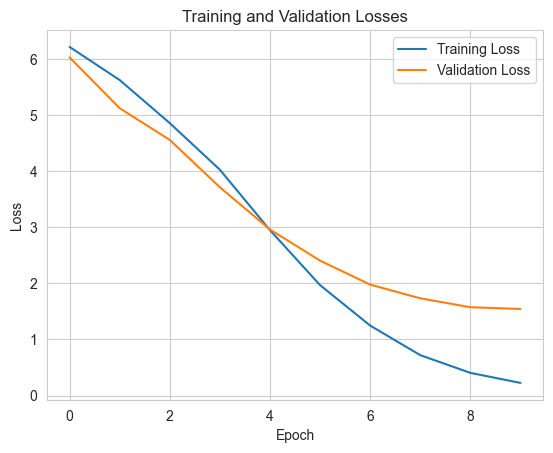

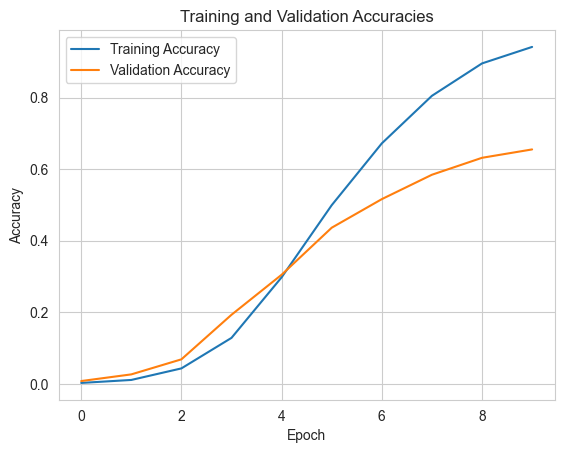

In [10]:
draw(train_losses, val_losses, val_full_acc, train_full_acc)

5 эпох действительно мало для обучения нейронной сети, хотя результат уже виден. Попробую дообучить еще 10 эпох, но при этом поменяв learning_rate на 0.0001, так как стандартно в оптимизаторе AdamW стоит 0.001, что является нормальным для первых эпох, но многовато для последующих.

In [11]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Epoch  1


Training: 100%|██████████| 267/267 [01:09<00:00,  3.82it/s]


train acc = 98.74%
val acc = 75.08%
Epoch  2


Training: 100%|██████████| 267/267 [01:10<00:00,  3.81it/s]


train acc = 99.79%
val acc = 75.35%
Epoch  3


Training: 100%|██████████| 267/267 [01:08<00:00,  3.90it/s]


train acc = 99.88%
val acc = 75.51%
Epoch  4


Training: 100%|██████████| 267/267 [01:09<00:00,  3.83it/s]


train acc = 99.94%
val acc = 76.04%
Epoch  5


Training: 100%|██████████| 267/267 [01:13<00:00,  3.65it/s]


train acc = 99.98%
val acc = 76.41%
Epoch  6


Training: 100%|██████████| 267/267 [01:10<00:00,  3.78it/s]


train acc = 99.94%
val acc = 76.84%
Epoch  7


Training: 100%|██████████| 267/267 [01:08<00:00,  3.88it/s]


train acc = 99.96%
val acc = 77.05%
Epoch  8


Training: 100%|██████████| 267/267 [01:11<00:00,  3.72it/s]


train acc = 99.96%
val acc = 77.21%
Epoch  9


Training: 100%|██████████| 267/267 [01:06<00:00,  4.00it/s]


train acc = 99.98%
val acc = 77.16%
Epoch  10


Training: 100%|██████████| 267/267 [01:07<00:00,  3.95it/s]


train acc = 99.96%
val acc = 77.32%
Время обучения: 756.4568605422974 секунд


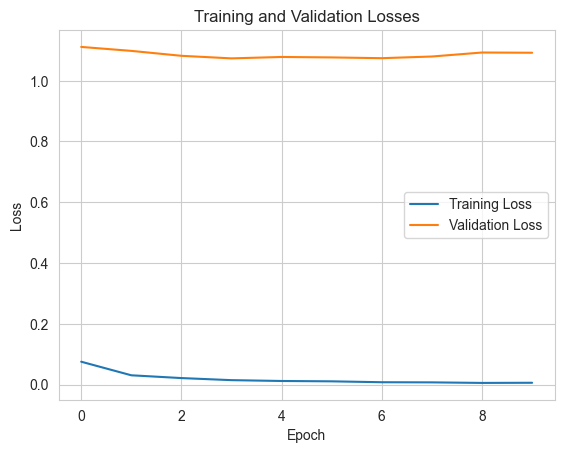

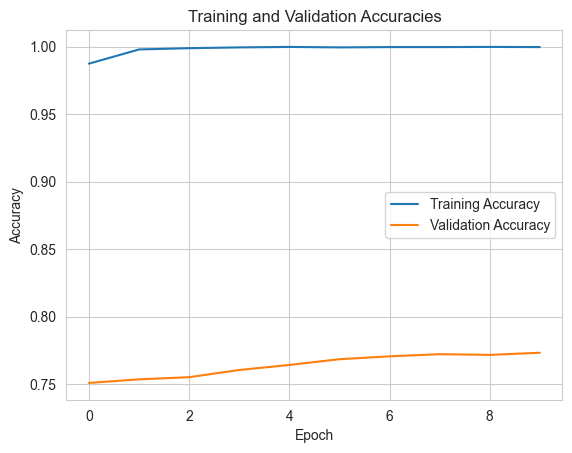

In [12]:
draw(train_losses, val_losses, val_full_acc, train_full_acc)

Получилось всего 77% на валидационной выборке, что относительно мало. Попробую другую модель, которая уже предобучена на датасете с фотографиями лиц и дообучу ее на своем датасете.


Возьмем модель Inception-Resnet-V1, так как она сочетает в себе идеи из архитектур Inception и Resnet и является одной из лучших моделей для распознавания лиц.

Основные особенности Inception-ResNet-V1:

1. Inception-модули позволяют сети эффективно масштабироваться и обрабатывать информацию на различных уровнях абстракции и масштабах. Это достигается за счет использования параллельных сверточных операций с различными размерами фильтров (1x1, 3x3, 5x5) и последующим объединением результатов.
2. Вместо того чтобы просто стекать слои, как в традиционных сетях, Inception-ResNet вводит остаточные соединения, которые позволяют градиентам течь непосредственно через архитектуру сети без ослабления на глубоких уровнях. Эти соединения помогают бороться с проблемой исчезающих градиентов при обучении очень глубоких сетей.

3. Так как Inception-ResNet-V1 использует идеи из Inception и Resnet, то гибридизация этих двух архитектур предлагает баланс между глубиной и шириной сети, что позволяет эффективно обрабатывать сложные признаки и обучаться быстрее по сравнению с отдельными архитектурами.


In [13]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

In [14]:
for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [16]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Epoch  1


Training:   0%|          | 0/267 [00:00<?, ?it/s]c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training: 100%|██████████| 267/267 [00:20<00:00, 13.34it/s]


train acc = 59.83%
val acc = 91.59%
Epoch  2


Training: 100%|██████████| 267/267 [00:20<00:00, 12.89it/s]


train acc = 91.14%
val acc = 93.18%
Epoch  3


Training: 100%|██████████| 267/267 [00:19<00:00, 13.36it/s]


train acc = 93.11%
val acc = 89.56%
Epoch  4


Training: 100%|██████████| 267/267 [00:19<00:00, 13.45it/s]


train acc = 93.13%
val acc = 93.02%
Epoch  5


Training: 100%|██████████| 267/267 [00:19<00:00, 13.39it/s]


train acc = 94.35%
val acc = 92.65%
Epoch  6


Training: 100%|██████████| 267/267 [00:19<00:00, 13.45it/s]


train acc = 94.73%
val acc = 92.28%
Epoch  7


Training: 100%|██████████| 267/267 [00:20<00:00, 12.83it/s]


train acc = 94.37%
val acc = 92.65%
Epoch  8


Training: 100%|██████████| 267/267 [00:20<00:00, 12.89it/s]


train acc = 93.81%
val acc = 92.01%
Epoch  9


Training: 100%|██████████| 267/267 [00:21<00:00, 12.65it/s]


train acc = 92.38%
val acc = 89.46%
Epoch  10


Training: 100%|██████████| 267/267 [00:20<00:00, 13.02it/s]


train acc = 93.41%
val acc = 91.53%
Время обучения: 245.04832458496094 секунд


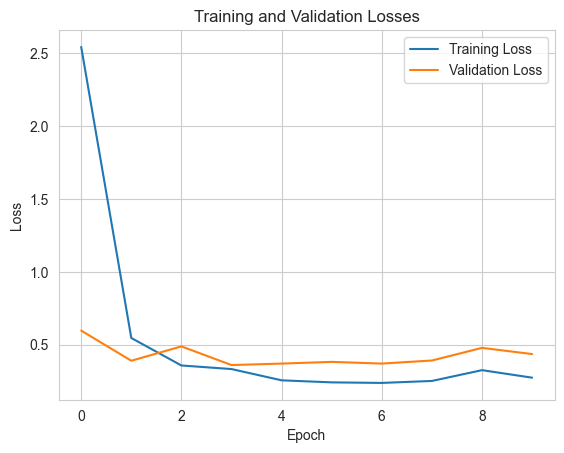

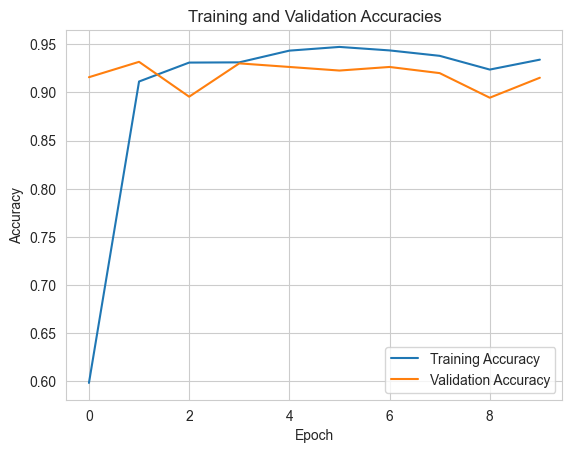

In [17]:
draw(train_losses, val_losses, val_full_acc, train_full_acc)

Опять же дообучим еще 10 эпох на learning_rate = 0.0001 для более точного схождения модели.

In [18]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [19]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Epoch  1


Training: 100%|██████████| 267/267 [00:20<00:00, 12.83it/s]


train acc = 94.41%
val acc = 93.72%
Epoch  2


Training: 100%|██████████| 267/267 [00:21<00:00, 12.65it/s]


train acc = 95.76%
val acc = 94.04%
Epoch  3


Training: 100%|██████████| 267/267 [00:20<00:00, 12.97it/s]


train acc = 95.90%
val acc = 94.25%
Epoch  4


Training: 100%|██████████| 267/267 [00:20<00:00, 13.10it/s]


train acc = 96.55%
val acc = 94.14%
Epoch  5


Training: 100%|██████████| 267/267 [00:20<00:00, 12.85it/s]


train acc = 96.70%
val acc = 93.93%
Epoch  6


Training: 100%|██████████| 267/267 [00:20<00:00, 12.87it/s]


train acc = 97.34%
val acc = 94.14%
Epoch  7


Training: 100%|██████████| 267/267 [00:20<00:00, 13.08it/s]


train acc = 96.00%
val acc = 91.59%
Epoch  8


Training: 100%|██████████| 267/267 [00:20<00:00, 12.84it/s]


train acc = 96.57%
val acc = 94.36%
Epoch  9


Training: 100%|██████████| 267/267 [00:20<00:00, 12.93it/s]


train acc = 96.79%
val acc = 93.77%
Epoch  10


Training: 100%|██████████| 267/267 [00:20<00:00, 13.27it/s]


train acc = 97.03%
val acc = 94.52%
Время обучения: 246.25068593025208 секунд


Отлично, получилось целых 93% на валидационной выборке. Выведу графики обучения.

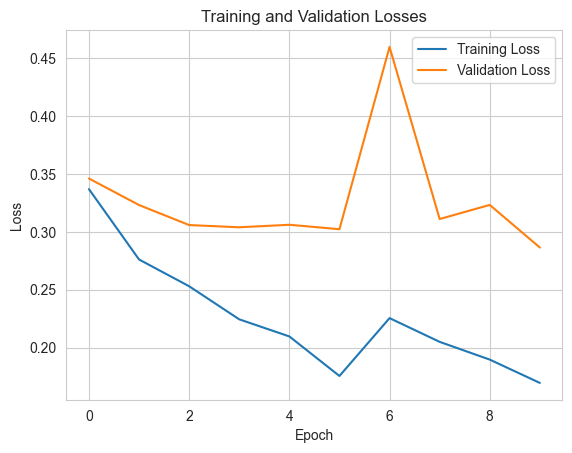

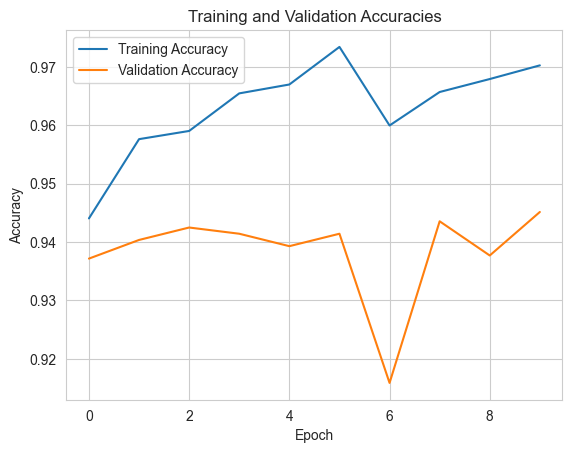

In [20]:
draw(train_losses, val_losses, val_full_acc, train_full_acc)

Посмотрим accuracy на тестовой выборке.

In [21]:
def test_result(model, test_loader):
    model.eval()
    with torch.no_grad():
        current_test_acc = 0
        for inputs, labels in test_loader:
            X_test = inputs.to(device)
            Y_test = labels.to(device)
            outputs = model(X_test)
            preds = torch.argmax(outputs, 1)
            current_test_acc += torch.sum(Y_test == preds)
    print('Correct answers: {} from {} '\
          .format(current_test_acc, len(test_data)))
    test_acc = current_test_acc / len(test_data)
    print('Test accuracy = {:.2f}%'.format(test_acc*100))

In [22]:
best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

best_model.load_state_dict(best_model_weights)

test_result(best_model.to(device), test_loader)

Correct answers: 1504 from 1589 
Test accuracy = 94.65%


c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [23]:
torch.save(best_model, 'best_model.pth')

In [25]:
models_dict = {'logistic regression':['4.2%',99],'random forest':['3.16%',40],'SVM':['6.65%',540], 'KNN':['2.62%',0.012],'GaussianNB':['2.03%',0.1],'CatBoost':['5.07%',193],'inception_resnet_v2': ['77.32%',756*2],'inception_resnet_v1': ['94.65%', 246*2]}
models_df = pd.DataFrame.from_dict(models_dict, orient='index', columns=['accuracy','time'])
models_df

,accuracy,time
logistic regression,4.2%,99.000
random forest,3.16%,40.000
SVM,6.65%,540.000
KNN,2.62%,0.012
GaussianNB,2.03%,0.100
CatBoost,5.07%,193.000
inception_resnet_v2,77.32%,1512.000
inception_resnet_v1,94.65%,492.000


## Вывод

Модели, основанные на глубоком обучении (например, Inception-ResNet-V1 и Inception-ResNet-V2), показали значительно более высокую точность по сравнению с традиционными методами машинного обучения, такими как логистическая регрессия, случайный лес и SVM. Inception-ResNet-V1 с точностью в 94.65% является наиболее успешной моделью в задачах идентификации личности, что подчеркивает преимущества использования сложных архитектур нейронных сетей для обработки и анализа изображений в таких задачах.

Несмотря на высокую точность, нейронные сети требуют значительно больше времени для обучения. Например, Inception-ResNet-V2 требовало 1512 секунд, в то время как более простые модели, такие как KNN, обучались менее чем за секунду. Это является минусом в случаях, когда необходимо быстро обучить модель и получить результаты.

Если сравнить эти результаты с аналогичными решениями в индустрии или академических кругах, можно заметить, что использование нейронных сетей показывает лучшие результапы в любых задачах, связанных с изображениями.

Сама модель имеет большую область применения в задачах безопасности, так как идентификация личности по изображению применяется в разблокировке смартфонов, доступах в какие-либо места по биометрии (например, в метро или офис), а также при входе в банковские приложения и т.д. Эти примеры демонстрируют широкий потенциал применения идентификации личности по изображению, подчеркивая её важность и многообещающие перспективы для дальнейшего развития и интеграции в различные аспекты повседневной жизни и бизнеса.

Рассуждая о перспективах развития модели, можно отметить, что для улучшения производительности и увеличения её устойчивости к изменениям во входных данных, можно использовать различные техники аугментации изображений. Это может включать изменения масштаба, повороты, изменение яркости и контрастности, что позволит модели лучше обобщать и работать с разнообразными условиями освещения и позами лиц. Кроме того, к улучшению точности модели может привести пополнение набора данных изображениями, которые лучше отражают целевую популяцию и различные условия окружающей среды. Кроме того помимо Inception-ResNet можно исследовать другие современные архитектуры, такие как EfficientNet или трансформеры для визуальных задач, которые показывают лучшие результаты. Также, поскольку идентификация личности по изображению часто применяется в задачах безопаности, необходимо принимать во внимание False positive rate (FPR), так как модель не должна давать положительный результат, когда на изображении на самом деле другая личность, поскольку это может привести к угрозе безопасности, что является критически важным в данном направлении.

Ссылка на репозиторий с кодом: https://github.com/yaromirgusev/course_work